## Imports

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import sklearn.decomposition as decomposition
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support
import pingouin as pg
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

path='C:/Repo/MiM_Analytics_Tesis/Tesis/'
#path='C:/Users/E0662122/Repo/MiM_Analytics_Tesis/Tesis/'

C:\Users\fabri\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
postgreSQL = {"host": "localhost", "port": "5432", "username": "postgres", 
               "password": "trivisono", "database": "SportsAnalytics"}

uri = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(postgreSQL['username'], postgreSQL['password'], postgreSQL['host'], postgreSQL['port'], postgreSQL['database'])

engine = create_engine(uri)
conn = engine.raw_connection()
cursor = conn.cursor()

In [3]:
df_perf_index = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt_season_players_train;", conn)

rating_correction = pd.read_sql_query("SELECT player_id, \
    SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) wavg_player_rating \
    FROM fdm.ft_api_matches_stats_players AS stats_players GROUP BY player_id \
    HAVING SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) IS NOT NULL", conn)

In [7]:
df_perf_index.to_csv(path+'AR_players_20220210.csv', encoding='utf-8', decimal='.', sep='|')
rating_correction.to_csv(path+'AR_rating_correction_20220203.csv', encoding='utf-8', decimal='.', sep='|')

In [4]:
df_perf_index

league_season  player_id        player_name player_preferred_position  \
0               2016          0               None                         M   
1               2016          1        Roman Burki                         G   
2               2016          2        Marwin Hitz                         G   
3               2016          7       Abdou Diallo                         D   
4               2016          8  Raphael Guerreiro                         D   
...              ...        ...                ...                       ...   
39478           2021     344881         Juan Tovar                         F   
39479           2021     344883        John Mendez                         F   
39480           2021     344937       Gabriel Bran                         G   
39481           2021     344938       Juan Espitia                         G   
39482           2021     345219     Felipe Ordonez                         M   

       player_preferred_number  team_id               team_name team_country  \
0                           15      453           Independiente    Argentina   
1                           38      165       Borussia Dortmund      Germany   
2                           35      170             FC Augsburg      Germany   
3                           34       91                  Monaco       France   
4                           13      165       Borussia Dortmund      Germany   
...                        ...      ...                     ...          ...   
39478                       14     1130                   Huila     Colombia   
39479                       26     1130                   Huila     Colombia   
39480                       32     1128  Independiente Medellin     Colombia   
39481                       12     1139                Santa Fe     Colombia   
39482                       32     1126         Deportivo Pasto     Colombia   

       avg_team_position  avg_league_cov  player_minutes  wavg_player_rating  \
0                   0.69            0.36            2182                 NaN   
1                   0.61            0.35            1080                6.66   
2                   0.11            0.35             900                6.35   
3                   1.00            0.43             386                7.22   
4                   0.61            0.35             773                7.18   
...                  ...             ...             ...                 ...   
39478               0.00            0.47               0                 NaN   
39479               0.00            0.47               0                 NaN   
39480               0.48            0.47               0                 NaN   
39481               0.67            0.47               0                 NaN   
39482               0.33            0.47              56                6.20   

       offsides  shots_total  shots_on_goal  goals_total  goals_conceded_padj  \
0             0           18              6            0                27.99   
1             0            0              0            0                20.11   
2             0            0              0            0                17.61   
3             0            2              0            0                 0.00   
4             0           17              6            3                 0.00   
...         ...          ...            ...          ...                  ...   
39478         0            0              0            0                 0.00   
39479         0            0              0            0                 0.00   
39480         0            0              0            0                 0.00   
39481         0            0              0            0                 0.00   
39482         0            0              0            0                 0.00   

       shots_on_goal_opp_padj  goals_assists  goals_saves_padj  passes_total  \
0                      129.45              1             15.84         

In [5]:
df = df_perf_index.copy()

In [19]:
df_scoring = df[df['team_country'].isin(['Argentina', 'Brazil', 'Mexico', 'Colombia', 'Peru', 'Chile'])].reset_index(drop=True)
df_scoring.to_csv(path+'AR_scoring_20220210.csv', encoding='utf-8', decimal='.', sep='|')

## Functions

In [6]:
def get_cronbach_alpha(df, df_factors, factors, threshold=0.5):
    list_c_alpha = []
    for factor in range(factors):
        cols_factor = df_factors[(~df_factors.index.isin(['Variance', 'Proportional Variance (%)', 'Cummulative (%)', 'Expl.Var/Tot (%)'])) & (df_factors[f'Factor {factor+1}']>=threshold)].index
        try:
            list_c_alpha.append([f'Sq Norm Factor {factor+1}', 
                                 pg.cronbach_alpha(df[cols_factor])[0], # C-Alpha
                                 pg.cronbach_alpha(df[cols_factor])[1]]) # Confidence Interval
        except:
            pass

    return pd.DataFrame(list_c_alpha, columns=['Factor', 'C-Alpha', 'Conf. Interval'])

In [7]:
def get_factors(x, factors, method='principal', rotation='varimax', thresh_c_alpha=0.5):
    fa = FactorAnalyzer(factors, method=method, rotation=rotation)
    fa.fit(x)
    # Get loadings
    loads = fa.loadings_
    # Get Variance
    var = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportional Variance (%)', 'Cummulative (%)'], 
                 columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    # Get Communalities
    communalities = pd.DataFrame(fa.get_communalities(), columns=['Communalities'], index=x.columns)
    # Calculate Normalized Squared Factor Loadings
    variances = fa.get_factor_variance()[0]
    sq_norm_variances = (loads**2)/variances
    variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]
    # Consolidate
    df_variances_pct = pd.DataFrame(variances_pct, index=['Factor {}'.format(fact+1) for fact in range(factors)], columns=['Expl.Var/Tot (%)']).transpose()
    df_sq_factors = pd.DataFrame(sq_norm_variances, index=x.columns, columns=['Sq Norm Factor {}'.format(fact+1) for fact in range(factors)])
    df_factors = pd.DataFrame(loads, index=x.columns, columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    df_weights = pd.DataFrame(np.sum(sq_norm_variances*variances_pct, axis=1), index=x.columns, columns=['PC_Weight'])
    df_factors_var = pd.concat([pd.concat([df_factors, var, df_variances_pct]), communalities, df_sq_factors, df_weights], axis=1)
    df_factors_var = df_factors_var.fillna('-')
    
    # Calculate Cronbach's coefficient alpha
    df_c_alpha = get_cronbach_alpha(x, df_factors_var, factors, threshold=thresh_c_alpha)
    
    return df_factors_var, df_c_alpha

## Preprocessing

In [8]:
df = df[(df['player_minutes']>=270) & (df['player_id']>0)].copy()

In [9]:
## Per 90 stats
# Attacking
df['offsides_p90'] = df['offsides']/df['player_minutes']*90
df['shots_p90'] = df['shots_total']/df['player_minutes']*90
df['shooting_accuracy'] = np.where(df['shots_total']==0, 0, np.where(df['shots_total']<df['shots_on_goal'], 1,
                                                                     df['shots_on_goal']/df['shots_total']))
df['goals_p90'] = df['goals_total']/df['player_minutes']*90
df['np_goals_p90'] = np.where(df['goals_total']-df['penalty_scored']<0, 0, 
                              (df['goals_total']-df['penalty_scored'])/df['player_minutes']*90)
df['goal_conversion'] = np.where(df['shots_total']==0, 0, df['goals_total']/df['shots_total'])
df['goal_conversion_np'] = np.where(df['shots_total']==0, 0, (df['goals_total']-df['penalty_scored'])/df['shots_total'])
df['assists_p90'] = df['goals_assists']/df['player_minutes']*90
df['penalty_won_p90'] = df['penalty_won']/df['player_minutes']*90
df['penalty_missed_p90'] = df['penalty_missed']/df['player_minutes']*90

# Build-up
df['passes_p90'] = df['passes_total']/df['player_minutes']*90
df['passing_accuracy'] = np.where(df['passes_total']==0, 0, df['passes_completed']/df['passes_total'])
df['key_passes_p90'] = df['passes_key']/df['player_minutes']*90
df['fouls_drawn_p90'] = df['fouls_drawn']/df['player_minutes']*90

# Defense
df['tackles_p90'] = df['tackles_total_padj']/df['player_minutes']*90
df['blocks_p90'] = df['tackles_blocks_padj']/df['player_minutes']*90
df['interceptions_p90'] = df['tackles_interceptions_padj']/df['player_minutes']*90
df['saves_p90'] = df['goals_saves_padj']/df['player_minutes']*90
df['penalty_saves_p90'] = df['penalty_saved']/df['player_minutes']*90
df['penalty_committed_p90'] = df['penalty_committed_padj']/df['player_minutes']*90
df['goals_conceded_p90'] = df['goals_conceded_padj']/df['player_minutes']*90
df['shots_on_goal_opp_p90'] = df['shots_on_goal_opp_padj']/df['player_minutes']*90
df['goals_conceded_ratio'] = df['goals_conceded_p90']/df['shots_on_goal_opp_p90']
df['fouls_committed_p90'] = df['fouls_committed_padj']/df['player_minutes']*90

# One vs one
df['duels_p90'] = df['duels_total_padj']/df['player_minutes']*90
df['duels_success_ratio'] = np.where(df['duels_total_padj']==0, 0, df['duels_won_padj']/df['duels_total_padj'])
df['dribbles_p90'] = df['dribbles_attemps']/df['player_minutes']*90
df['dribbles_success_ratio'] = np.where(df['dribbles_attemps']==0, 0, df['dribbles_success']/df['dribbles_attemps'])
df['dribbles_past_p90'] = df['dribbles_past_padj']/df['player_minutes']*90

# General
df['cards_yellow_p90'] = df['cards_yellow']/df['player_minutes']*90
df['cards_red_p90'] = df['cards_red']/df['player_minutes']*90

# Combined
df['scoring_contribution'] = df['np_goals_p90']+df['assists_p90']

In [10]:
# Fill NAs rating with ratings from the same players in other seasons
df = df.merge(rating_correction, on=['player_id'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating_x'].isna(), df['wavg_player_rating_y'], df['wavg_player_rating_x'])
del df['wavg_player_rating_x'], df['wavg_player_rating_y']

# Fill NAs rating with average rating of the position in the entire dataset
df_ratings_pos = df[['player_preferred_position', 'wavg_player_rating']].groupby(['player_preferred_position']).median().rename(
    columns={'wavg_player_rating': 'wavg_position_rating'}).reset_index()
df = df.merge(df_ratings_pos, on=['player_preferred_position'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating'].isna(), df['wavg_position_rating'], df['wavg_player_rating'])
del df['wavg_position_rating']

In [11]:
df.to_csv(path+'AR_players_season_20220210.csv', encoding='utf-8', decimal='.', sep='|')

### Variable Selection

In [12]:
player_cols = ['league_season', 'team_id', 'team_name', 'player_id', 'player_name', 'player_preferred_position', 'wavg_player_rating']

fw_cols = ['np_goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion_np', 'passing_accuracy', 'assists_p90', 
           'key_passes_p90', 'dribbles_p90', 'dribbles_success_ratio', #'scoring_contribution', 
           'tackles_p90', 'interceptions_p90']#, 'avg_team_position', 'avg_league_cov'] 

mf_cols = ['passes_p90', 'passing_accuracy', 'key_passes_p90', 'scoring_contribution', 'dribbles_p90', 'dribbles_success_ratio', 
           'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 'tackles_p90',  'interceptions_p90']#, 'avg_team_position', 'avg_league_cov']

df_cols = ['passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_padj', 'scoring_contribution', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']#, 'avg_team_position', 'avg_league_cov']


gk_cols = ['saves_p90', 'goals_conceded_p90', 'goals_conceded_ratio', 'passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90',
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']#, 'avg_team_position', 'avg_league_cov']

### Unification of Optimizing Direction for all Variables

In [13]:
df['fouls_committed_p90'] = df['fouls_committed_p90']*-1
df['dribbles_past_p90'] = df['dribbles_past_p90']*-1
df['dribbles_past_padj'] = df['dribbles_past_padj']*-1
df['penalty_committed_p90'] = df['penalty_committed_p90']*-1
df['goals_conceded_p90'] = df['goals_conceded_p90']*-1

### Normalization

In [14]:
df_fw_0 = df[df['player_preferred_position'] == 'F'][player_cols+fw_cols].copy()
df_mf_0 = df[df['player_preferred_position'] == 'M'][player_cols+mf_cols].copy()
df_df_0 = df[df['player_preferred_position'] == 'D'][player_cols+df_cols].copy()
df_gk_0 = df[df['player_preferred_position'] == 'G'][player_cols+gk_cols].copy()

In [15]:
df_fw = pd.concat([df_fw_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_fw_0[fw_cols]), columns=fw_cols)], axis=1)

df_mf = pd.concat([df_mf_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_mf_0[mf_cols]), columns=mf_cols)], axis=1)

df_df = pd.concat([df_df_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_df_0[df_cols]), columns=df_cols)], axis=1)

df_gk = pd.concat([df_gk_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_gk_0[gk_cols]), columns=gk_cols)], axis=1)

## Factor Analysis

In [78]:
position = 'Forward'
cols_train = fw_cols
df_train = df_fw.copy()

In [79]:
if position == 'Goalkeeper':
    df_train = df_train[(df_train['player_id'] != 39625) & (df_train['tackles_p90']<20)]

### Train

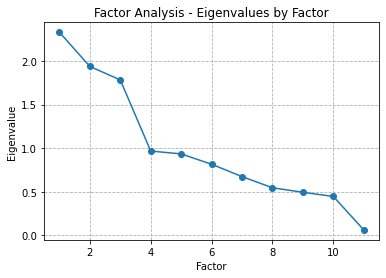

In [80]:
# Fit Factor Analyzer
x = df_train[cols_train]
fa = FactorAnalyzer()
fa.fit(x, 20)
# Get Eigenvalues and plot them
ev, v = fa.get_eigenvalues()
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(range(1,x.shape[1]+1),ev,marker='o')
plt.title('Factor Analysis - Eigenvalues by Factor')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid(linestyle='--')
plt.savefig(path+'plots_and_tables/'+position+'_FactorAnalysis_ExplainedVariance.png')

Stopping rules criteria used: 

- Scree plot (retain all eigenvalues in the sharp descent before the first one on the line where they start to level off)
- Kaiser criterion (drop all factors with eigenvalues below 1.0)
- Variance explained (keep enough factors to account for 60% of the variation)

In [81]:
# Fit Factor Analyzer
factors=5
method='principal'
rotation='varimax'

fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_
variances = fa.get_factor_variance()[0]
sq_norm_variances = (loads**2)/variances
variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]

In [82]:
display(get_factors(x, factors=factors, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=factors, method='principal', rotation='varimax')[1])

Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  \
np_goals_p90                   0.89      0.03      0.37      0.02     -0.07   
shots_p90                      0.22      0.09      0.77      0.10     -0.08   
shooting_accuracy              0.70      0.07     -0.36      0.01     -0.06   
goal_conversion_np             0.91     -0.02     -0.05     -0.04     -0.05   
passing_accuracy              -0.23      0.03      0.78     -0.05      0.02   
assists_p90                    0.05      0.88     -0.00     -0.03      0.00   
key_passes_p90                -0.00      0.80      0.11      0.11      0.25   
dribbles_p90                  -0.05      0.29      0.09      0.16      0.67   
dribbles_success_ratio        -0.02      0.07      0.01      0.96      0.05   
tackles_p90                    0.06     -0.02     -0.42      0.15      0.60   
interceptions_p90             -0.13      0.04      0.00     -0.15      0.78   
Variance                       2.23      1.53      1.68      1.03      1.50   
Proportional Variance (%)      0.20      0.14      0.15      0.09      0.14   
Cummulative (%)                0.20      0.34      0.49      0.59      0.72   
Expl.Var/Tot (%)               0.28      0.19      0.21      0.13      0.19   

                          Communalities Sq Norm Factor 1 Sq Norm Factor 2  \
np_goals_p90                       0.93             0.35             0.00   
shots_p90                          0.67             0.02             0.01   
shooting_accuracy                  0.63             0.22             0.00   
goal_conversion_np                 0.83             0.37             0.00   
passing_accuracy                   0.67             0.02             0.00   
assists_p90                        0.79             0.00             0.51   
key_passes_p90                     0.72             0.00             0.42   
dribbles_p90                       0.57             0.00             0.06   
dribbles_success_ratio             0.93             0.00             0.00   
tackles_p90                        0.56             0.00             0.00   
interceptions_p90                  0.65             0.01             0.00   
Variance                              -                -                -   
Proportional Variance (%)             -                -                -   
Cummulative (%)                       -                -                -   
Expl.Var/Tot (%)                      -                -                -   

                          Sq Norm Factor 3 Sq Norm Factor 4 Sq Norm Factor 5  \
np_goals_p90                          0.08             0.00             0.00   
shots_p90                             0.36             0.01             0.00   
shooting_accuracy                     0.08             0.00             0.00   
goal_conversion_np                    0.00             0.00             0.00   
passing_accuracy                      0.36             0.00             0.00   
assists_p90                           0.00             0.00             0.00   
key_passes_p90                        0.01             0.01             0.04   
dribbles_p90                          0.01             0.03             0.30   
dribbles_success_ratio                0.00             0.90             0.00   
tackles_p90                           0.11             0.02             0.24   
interceptions_p90                     0.00             0.02             0.41   
Variance                                 -                -                -   
Proportional Variance (%)                -                -                -   
Cummulative (%)                          -                -                -   
Expl.Var/Tot (%)                         -                -                -   

                          PC_Weight  
np_goals_p90                   0.12  
shots_p90                      0.08  
shooting_accuracy              0.08  
goal_conversion_np             0.10  
passing_accuracy               0.08  
assists_p90         

Factor  C-Alpha  Conf. Interval
0  Sq Norm Factor 1     0.79  [0.784, 0.803]
1  Sq Norm Factor 2     0.64  [0.616, 0.655]
2  Sq Norm Factor 3     0.44  [0.413, 0.472]
3  Sq Norm Factor 5     0.50  [0.477, 0.523]

In [83]:
df_factors = get_factors(x, factors=factors, method='principal', rotation='varimax')[0]
df_variances = df_factors.iloc[df_factors.index == 'Expl.Var/Tot (%)', 0:factors]
df_variances

Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
Expl.Var/Tot (%)      0.28      0.19      0.21      0.13      0.19

### Scoring

In [84]:
def score_performance_index(df_factors, df_train, player_cols, train_cols, sensitivity=False, df_sensitivity=None):
    
    # Weights calculation
    weights_f1 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -6])
    weights_f2 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -5])
    weights_f3 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -4])
    weights_f4 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -3])
    weights_f5 = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -2])
    weights = np.array(df_factors.iloc[:-(len(df_factors)-len(cols_train)), -1])
    
    # Scoring
    df_perf_idx = df_train.set_index(player_cols)[cols_train]
    df_perf_idx['Factor_1'] = np.sum(df_perf_idx[cols_train]*weights_f1, axis=1)
    df_perf_idx['Factor_2'] = np.sum(df_perf_idx[cols_train]*weights_f2, axis=1)
    df_perf_idx['Factor_3'] = np.sum(df_perf_idx[cols_train]*weights_f3, axis=1)
    df_perf_idx['Factor_4'] = np.sum(df_perf_idx[cols_train]*weights_f4, axis=1)
    df_perf_idx['Factor_5'] = np.sum(df_perf_idx[cols_train]*weights_f5, axis=1)
    df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[cols_train]*weights, axis=1)
    
    # Scaling
    df_perf_idx['Factor_1_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_1']))
    df_perf_idx['Factor_2_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_2']))
    df_perf_idx['Factor_3_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_3']))
    df_perf_idx['Factor_4_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_4']))
    df_perf_idx['Factor_5_scaled'] = MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Factor_5']))
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(pd.DataFrame(df_perf_idx['Perf_Index']))
    df_perf_idx['Perf_Index_scaled'] = scaler.transform(pd.DataFrame(df_perf_idx['Perf_Index']))
    
    if sensitivity:
        df_sensitivity['Perf_Index'] = np.sum(df_sensitivity[cols_train]*weights, axis=1)
        df_sensitivity['Perf_Index_scaled'] = scaler.transform(pd.DataFrame(df_sensitivity['Perf_Index']))
        return df_sensitivity        
    else:
        return df_perf_idx        

In [85]:
df_perf_idx = score_performance_index(df_factors, df_train, player_cols, cols_train)

### Evaluation

In [86]:
cols_analysis = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Perf_Index', 
                 'Factor_1_scaled', 'Factor_2_scaled', 'Factor_3_scaled', 'Factor_4_scaled', 'Factor_5_scaled', 'Perf_Index_scaled']
df_idx_analysis = df_perf_idx[cols_analysis].reset_index().sort_values('Perf_Index_scaled', ascending=False)

In [87]:
scaler = StandardScaler()
scaler = scaler.fit(pd.DataFrame(df_idx_analysis['Perf_Index_scaled']))
df_idx_analysis['Perf_Index_norm'] = scaler.transform(pd.DataFrame(df_idx_analysis['Perf_Index_scaled']))

#df_idx_all_players = pd.DataFrame()
df_idx_all_players = pd.concat([df_idx_all_players, df_idx_analysis], ignore_index=True)

In [89]:
#df_idx_all_players.to_csv(path+'20220524_AllPlayersNormIndex.csv', encoding='utf-8', decimal='.', sep='|')

In [43]:
df_idx_analysis['cat_player_rating'] = np.select([df_idx_analysis['wavg_player_rating']<6.5,
                                                  df_idx_analysis['wavg_player_rating']<7,
                                                  df_idx_analysis['wavg_player_rating']<7.5,
                                                  df_idx_analysis['wavg_player_rating']<8,
                                                  df_idx_analysis['wavg_player_rating']<8.5], 
                                                 ['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5'], default=['8.5-10'])

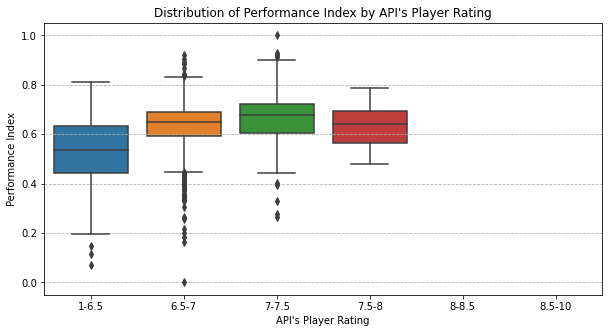

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="cat_player_rating", y="Perf_Index_scaled", data=df_idx_analysis,
            order=['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-10'], ax=ax)
ax.set_title("Distribution of Performance Index by API's Player Rating")
ax.set_ylabel("Performance Index")
ax.set_xlabel("API's Player Rating")
ax.yaxis.grid(linestyle='--')
plt.savefig(path+'plots_and_tables/'+position+'_BoxPlot_PerfIndex_RatingRevision.png')

In [45]:
df_idx_analysis[(df_idx_analysis['Perf_Index_scaled']>0.8) & df_idx_analysis['wavg_player_rating'].between(7,7.5)]

league_season  team_id            team_name  player_id  \
1496           2019     2540        Universitario      39868   
615            2017      209            Feyenoord      37137   
353            2017       42              Arsenal        313   
310            2016     1146             Cortulua      81642   
1148           2018     2554           FBC Melgar     100901   
761            2018       42              Arsenal       1436   
922            2018     1129             Envigado      13457   
1053           2018     2546     Sporting Cristal      39473   
873            2018      131          Corinthians      10226   
59             2016      228          Sporting CP       2673   
129            2016      127             Flamengo      10476   
171            2016     1305               Bastia      20875   
15             2016      174        FC Schalke 04        396   
188            2016      181      SV Darmstadt 98      25363   
2116           2021     2289                 Leon      35473   
1616           2020      738     Waasland-beveren       1923   
1673           2020      446                Lanus       6196   
905            2018     2326      Union La Calera      11871   
506            2017     1134           La Equidad      13600   
1054           2018     2542          Ayacucho FC      39475   
786            2018      451         Boca Juniors       2462   
403            2017      446                Lanus       2462   
1003           2018     2279          Tigres UANL      35507   
1321           2019     2318            Palestino      11594   
2071           2021     2994          U. Catolica      11346   
1684           2020      437      Rosario Central       6493   
868            2018      134  Atletico Paranaense      10112   
1576           2020      417             Waalwijk        525   
390            2017       85  Paris Saint Germain       1800   

               player_name player_preferred_position  wavg_player_rating  \
1496       Patrick Zubczuk                         G                7.10   
615          Justin Bijlow                         G                7.00   
353           David Ospina                         G                7.06   
310         Jaiber Cardona                         G                7.37   
1148          Diego Campos                         G                7.22   
761              Petr Cech                         G                7.13   
922     Jefferson Martinez                         G                7.16   
1053         Carlos Grados                         G                7.18   
873                 Walter                         G                7.18   
59                    Beto                         G                7.23   
129           Paulo Victor                         G                7.48   
171      Thomas Vincensini                         G                7.33   
15           Ralf Fahrmann                         G                7.01   
188          Michael Esser                         G                7.23   
2116          Rodolfo Cota                         G                7.28   
1616        Nordin Jackers                         G                7.45   
1673       Lautaro Morales                         G                7.14   
905       Claudio Gonzales                         G                7.03   
506       Kevin Piedrahita                         G                7.27   
1054            Andy Vidal                         G                7.17   
786        Esteban Andrada                         G                7.48   
403        Esteban Andrada                         G                7.05   
1003         Nahuel Guzman                         G                7.00   
1321      Ignacio Gonzalez                         G                7.10   
2071         Matias Dituro                         G                7.14   
1684  Marcelo Agustin Mino                         G                7.21   
868                 Santos       

In [60]:
df_idx_analysis[['Perf_Index_scaled', 'wavg_player_rating']].corr()

Perf_Index_scaled  wavg_player_rating
Perf_Index_scaled                1.00                0.35
wavg_player_rating               0.35                1.00

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


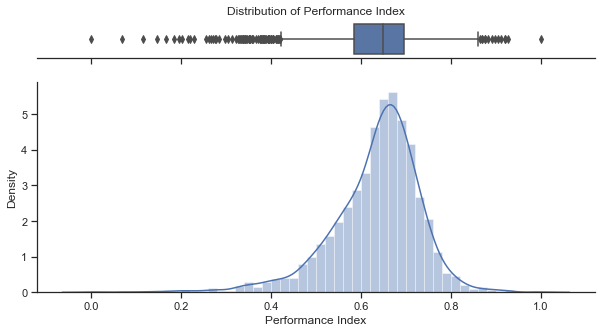

In [61]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10, 5),
                                      gridspec_kw={"height_ratios": (.15, .85)})
sns.set(style="ticks")
sns.boxplot(df_idx_analysis['Perf_Index_scaled'], ax=ax_box)
sns.distplot(df_idx_analysis['Perf_Index_scaled'], ax=ax_hist)

ax_box.set(yticks=[], xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_box.set_title("Distribution of Performance Index")
ax_hist.set_xlabel('Performance Index')
plt.savefig(path+'plots_and_tables/'+position+'_PerfIndex_DistributionRevision.png')

In [71]:
df_idx_analysis[df_idx_analysis['Perf_Index_scaled']>0.85][['player_name', 'team_name', 'league_season', 'Perf_Index_scaled']]

player_name            team_name  league_season  Perf_Index_scaled
866              Neymar  Paris Saint Germain           2017               1.00
4028        Luis Muriel             Atalanta           2020               0.99
395   Gabriel Boschilia               Monaco           2016               0.97
1795       Lionel Messi            Barcelona           2018               0.95
850        Lionel Messi            Barcelona           2017               0.93
2830       Lionel Messi            Barcelona           2019               0.90
2818       Jadon Sancho    Borussia Dortmund           2019               0.89
1810      Donyell Malen        PSV Eindhoven           2018               0.89
2918           Paulinho     Bayer Leverkusen           2019               0.88
105        Luis Alberto                Lazio           2016               0.88
1928      Clinton N'Jie            Marseille           2018               0.88
3474       Josip Ilicic             Atalanta           2019               0.86
9          Lionel Messi            Barcelona           2016               0.86
2849      Kylian Mbappe  Paris Saint Germain           2019               0.85

In [48]:
df_idx_analysis[df_idx_analysis['player_name']== 'Franco Armani']

league_season  team_id          team_name  player_id    player_name  \
1632           2020      435        River Plate       2463  Franco Armani   
52             2016     1137  Atletico Nacional       2463  Franco Armani   
404            2017     1137  Atletico Nacional       2463  Franco Armani   
787            2018      435        River Plate       2463  Franco Armani   
2000           2021      435        River Plate       2463  Franco Armani   
1217           2019      435        River Plate       2463  Franco Armani   

     player_preferred_position  wavg_player_rating  Factor_1  Factor_2  \
1632                         G                6.51      2.77     -0.07   
52                           G                7.07      0.13      0.03   
404                          G                7.04     -0.01      0.07   
787                          G                7.31      0.01     -0.23   
2000                         G                6.93      0.00     -0.28   
1217                         G                6.91     -0.54     -0.12   

      Factor_3  Factor_4  Factor_5  Perf_Index  Factor_1_scaled  \
1632     -1.04      0.43      1.46        0.79             0.75   
52        0.17      0.14      0.27        0.13             0.48   
404       0.13      0.13      0.26        0.10             0.46   
787       0.18      0.12      0.36        0.06             0.47   
2000      0.10      0.09     -0.07       -0.04             0.46   
1217      0.13      0.03      0.27       -0.10             0.41   

      Factor_2_scaled  Factor_3_scaled  Factor_4_scaled  Factor_5_scaled  \
1632             0.42             0.52             0.23             0.64   
52               0.47             0.73             0.20             0.46   
404              0.48             0.72             0.20             0.46   
787              0.36             0.73             0.20             0.48   
2000             0.34             0.72             0.20             0.41   
1217             0.41             0.72             0.19             0.46   

      Perf_Index_scaled cat_player_rating  
1632               0.76             6.5-7  
52                 0.55             7-7.5  
404                0.54             7-7.5  
787                0.53             7-7.5  
2000               0.50             6.5-7  
1217               0.48             6.5-7

In [49]:
import plotly.graph_objects as go

player_name = 'Franco Armani'
season = 2020

# Player
factors_cols = ['player_name',  'Factor_1_scaled', 'Factor_2_scaled', 'Factor_3_scaled', 'Factor_4_scaled', 'Factor_5_scaled']
player_mask = (df_idx_analysis['player_name']==player_name) & (df_idx_analysis['league_season']==season)
df_player_radar = round(df_idx_analysis[player_mask][factors_cols].set_index('player_name')*100)
player_values = df_player_radar.values.flatten().tolist()
player_values += player_values[:1]

# Avg Player
factor1_avg = df_idx_analysis['Factor_1_scaled'].mean()
factor2_avg = df_idx_analysis['Factor_2_scaled'].mean()
factor3_avg = df_idx_analysis['Factor_3_scaled'].mean()
factor4_avg = df_idx_analysis['Factor_4_scaled'].mean()
factor5_avg = df_idx_analysis['Factor_5_scaled'].mean()
df_avg_player = round(pd.DataFrame({'AvgPlayer': 
                                    [factor1_avg, factor2_avg, factor3_avg, factor4_avg, factor5_avg]}).transpose()*100)
avg_player_values = df_avg_player.values.flatten().tolist()
avg_player_values += avg_player_values[:1]

if position == 'Forward':
    categories = ['Efectiveness','Assistance','Attack','Dribbling', 'Defense']
if position == 'Midfielder':
    categories = ['Attack', 'Defense','Passing','Aggressiveness', 'Dribbling']
if position == 'Defender':
    categories = ['Aggressiveness','Passing','Duels','Penalties', 'Interceptions']
if position == 'Goalkeeper':
    categories = ['Defense','Passing','Clean Sheets','Duels', 'Saves']
    
categories = [*categories, categories[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=avg_player_values, theta=categories, fill='toself', name='Avg Goalkeeper'),
        go.Scatterpolar(r=player_values, theta=categories, fill='toself', name=player_name)
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Player comparison'),
        polar={'radialaxis': {'visible': True, 'range': [0, 100]}},
        showlegend=True
    )
)

fig
fig.write_image('plots_and_tables/'+position+'_RadarChart_Armani2020.png')

### Sensitivity Analysis

In [95]:
position = 'Goalkeeper'
cols_train = gk_cols
df_train = df_gk.copy()

In [97]:
if position == 'Goalkeeper':
    df_train = df_train[(df_train['player_id'] != 39625) & (df_train['tackles_p90']<20)]

In [98]:
factors=5
df_factors = get_factors(df_train[cols_train], factors=factors, method='principal', rotation='varimax')[0]

In [99]:
min_list = []
half_step_min = []
mean_list = []
half_step_max = []
max_list = []

for col in cols_train:
    min_list.append(df_train[col].min()) 
    half_step_min.append((df_train[col].mean()+df_train[col].min())/2) 
    mean_list.append(df_train[col].mean())
    half_step_max.append((df_train[col].max()+df_train[col].mean())/2) 
    max_list.append(df_train[col].max()) 

In [100]:
df_sens = pd.DataFrame([min_list, half_step_min, mean_list, half_step_max, max_list], 
             index=['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max'], columns=cols_train)

In [102]:
dict_all = {}
dict_step = {}

for col in df_sens.columns:
    for step in ['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max']:
        list_vars = list(cols_train)
        list_vars.remove(col)
        df_iter = pd.DataFrame(pd.concat([pd.Series(df_sens.loc[step, col], name=col), df_sens.loc['Mean', list_vars]])).transpose()
        df_iter.columns = df_sens.columns
        df_scored = score_performance_index(df_factors, df_train, player_cols, cols_train, True, df_iter)
        dict_step[step] = df_scored.loc[0,'Perf_Index_scaled']
        dict_all[col] = dict(dict_step)

In [68]:
df_scored_steps = pd.DataFrame.from_dict(dict_all)

In [69]:
for col in df_scored_steps.columns:
    df_scored_steps[col] = (df_scored_steps[col]/df_scored_steps.loc['Mean', col]-1)*100

In [70]:
df_plot = df_scored_steps.transpose()

In [71]:
df_plot['Min'] = df_plot['Min']-df_plot['Half_Min']
df_plot['Max'] = df_plot['Max']-df_plot['Half_Max']

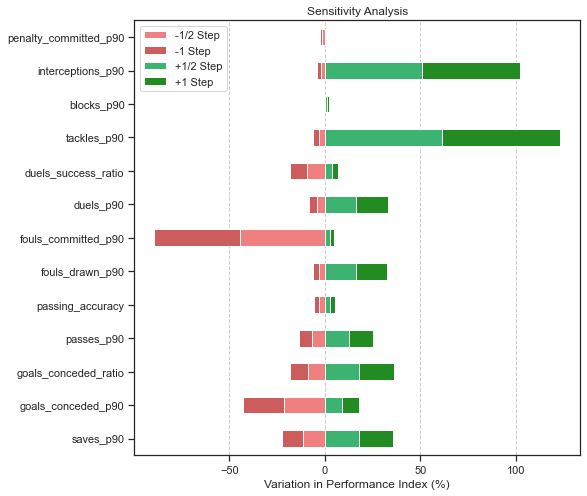

In [72]:
plot_cols = ['Half_Min', 'Min', 'Half_Max', 'Max']

fig, ax = plt.subplots(figsize=(8, 8))

df_plot[plot_cols].plot(kind='barh', stacked=True, ax=ax, color=['lightcoral', 'indianred', 'mediumseagreen', 'forestgreen'])
ax.set_xlabel('Variation in Performance Index (%)')
ax.legend(['-1/2 Step', '-1 Step', '+1/2 Step', '+1 Step'])
ax.xaxis.grid(linestyle='--')
ax.set_title('Sensitivity Analysis')

fig.savefig(path+'plots_and_tables/'+position+'_SensitivityAnalysisRevision.png', bbox_inches='tight', pad_inches=1)

In [108]:
def sensitivity_analysis(df, dict_perf_index, path):

    dict_sensitivity_plots = {}

    for position in ['F', 'M', 'D', 'G']:

        df_index = df[df['player_preferred_position'] == position].reset_index(drop=True)

        # Extract steps values
        min_list = []
        half_step_min = []
        mean_list = []
        half_step_max = []
        max_list = []

        for col in dict_perf_index['cols'][position]:
            min_list.append(df_index[col].min())
            half_step_min.append((df_index[col].mean()+df_index[col].min())/2)
            mean_list.append(df_index[col].mean())
            half_step_max.append((df_index[col].max()+df_index[col].mean())/2)
            max_list.append(df_index[col].max())

        df_sensitivity = pd.DataFrame([min_list, half_step_min, mean_list, half_step_max, max_list],
                                      index=['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max'],
                                      columns=dict_perf_index['cols'][position])

        # Calculate index variations
        dict_all = {}
        dict_step = {}

        for col in df_sensitivity.columns:
            for step in ['Min', 'Half_Min', 'Mean', 'Half_Max', 'Max']:
                list_vars = list(dict_perf_index['cols'][position])
                list_vars.remove(col)
                df_iter = pd.DataFrame(pd.concat([pd.Series(df_sensitivity.loc[step, col], name=col),
                                                  df_sensitivity.loc['Mean', list_vars]])).transpose()
                df_iter.columns = df_sensitivity.columns
                df_iter['Perf_Index'] = np.sum(df_iter[dict_perf_index['cols'][position]]**dict_perf_index['index_weights'][position]['Weights'], axis=1)
                df_iter['Perf_Index_scaled'] = dict_perf_index['index_weights']['index_scaler'].transform(pd.DataFrame(df_iter['Perf_Index']))
                dict_step[step] = df_iter.loc[0, 'Perf_Index_scaled']
                dict_all[col] = dict(dict_step)

        df_scored_steps = pd.DataFrame.from_dict(dict_all)

        # Calculate percentual variation
        for col in df_scored_steps.columns:
            df_scored_steps[col] = (df_scored_steps[col]/df_scored_steps.loc['Mean', col]-1)*100

        # Plot variations
        df_plot = df_scored_steps.transpose()
        df_plot['Min'] = df_plot['Min']-df_plot['Half_Min']
        df_plot['Max'] = df_plot['Max']-df_plot['Half_Max']
        plot_cols = ['Half_Min', 'Min', 'Half_Max', 'Max']

        fig, ax = plt.subplots(figsize=(8, 8))
        df_plot[plot_cols].plot(kind='barh', stacked=True, ax=ax, color=['lightcoral', 'indianred', 'mediumseagreen', 'forestgreen'])
        ax.set_xlabel('Variation in Performance Index (%)')
        ax.legend(['-1/2 Step', '-1 Step', '+1/2 Step', '+1 Step'])
        ax.xaxis.grid(linestyle='--')
        fig.savefig(path+'SensitivityAnalysis_' + position + '.png', bbox_inches='tight', pad_inches=1)

## Analysis All Positions

In [105]:
df_idx_all_players = pd.read_csv(path+'20220524_AllPlayersNormIndex.csv', encoding='utf-8', decimal='.', sep='|')

In [106]:
df_idx_all_players

Unnamed: 0  league_season  team_id        team_name  player_id  \
0               0           2019     2540    Universitario      39868   
1               1           2017      209        Feyenoord      37137   
2               2           2018     2328       Huachipato      11657   
3               3           2017       42          Arsenal        313   
4               4           2016     1146         Cortulua      81642   
...           ...            ...      ...              ...        ...   
28961       28961           2021     2315        Colo Colo      11431   
28962       28962           2020     1063    Saint Etienne      24811   
28963       28963           2020      762      GIL Vicente     112386   
28964       28964           2016      461  San Martin S.J.       5592   
28965       28965           2021     2316     Curico Unido     337948   

             player_name player_preferred_position  wavg_player_rating  \
0        Patrick Zubczuk                         G                7.10   
1          Justin Bijlow                         G                7.00   
2             Yerko Urra                         G                6.60   
3           David Ospina                         G                7.06   
4         Jaiber Cardona                         G                7.37   
...                  ...                       ...                 ...   
28961  Carlos Villanueva                         F                6.54   
28962    Anthony Modeste                         F                6.53   
28963              Renan                         F                6.58   
28964       Diego Chaves                         F                6.50   
28965         Ian Aliaga                         F                6.48   

       Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Perf_Index  \
0          0.32      2.46     -0.19      0.11      1.68        0.88   
1          0.34      1.61     -0.57      0.10      2.18        0.69   
2          1.40      1.52      0.45      0.07     -0.67        0.67   
3          0.17      2.52      0.14      0.15     -0.04        0.67   
4         -0.27      2.37     -0.13      0.13      1.08        0.65   
...         ...       ...       ...       ...       ...         ...   
28961     -1.33     -0.39     -0.95     -2.07     -0.05       -0.92   
28962     -1.11     -0.55     -0.49     -2.36     -0.55       -0.93   
28963     -0.69     -0.99     -0.79     -2.37     -0.40       -0.93   
28964     -1.15     -0.86     -0.38     -2.38     -0.59       -0.99   
28965     -1.36     -0.46     -1.03     -2.33     -0.03       -0.99   

       Factor_1_scaled  Factor_2_scaled  Factor_3_scaled  Factor_4_scaled  \
0                 0.54             0.98             0.66             0.99   
1                 0.54             0.78             0.60             0.99   
2                 0.92             0.75             0.78             0.99   
3                 0.48             0.99             0.72             1.00   
4                 0.33             0.96             0.68             1.00   
...                ...              ...              ...              ...   
28961             0.01             0.11             0.14             0.07   
28962             0.05             0.08             0.29             0.01   
28963             0.14             0.00             0.19             0.00   
28964             0.04             0.02             0.32             0.00   
28965             0.00             0.09             0.12             0.01   

       Factor_5_scaled  Perf_Index_scaled cat_player_rating  Perf_Index_norm  
0                 0.65               1.00             7-7.5             3.67  
1                 0.73               0.93             7-7.5             2.94  
2                 0.27               0.92             6.5-7             2.88  
3                 0.37               0.92             7-7.5             2.87  
4                 0.55               0.91             7-7.5         

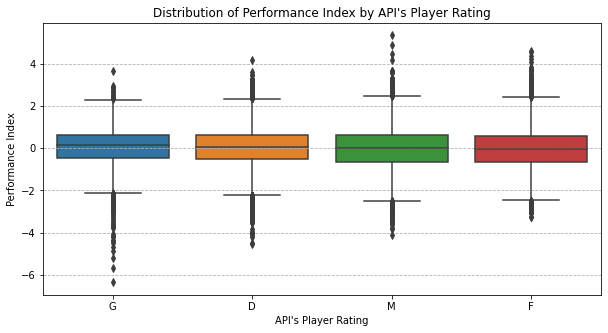

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="player_preferred_position", y="Perf_Index_norm", data=df_idx_all_players, ax=ax)
ax.set_title("Distribution of Performance Index by API's Player Rating")
ax.set_ylabel("Performance Index")
ax.set_xlabel("API's Player Rating")
ax.yaxis.grid(linestyle='--')

In [109]:
df_idx_all_players['cat_player_rating'] = np.select([df_idx_all_players['wavg_player_rating']<6.5,
                                                  df_idx_all_players['wavg_player_rating']<7,
                                                  df_idx_all_players['wavg_player_rating']<7.5,
                                                  df_idx_all_players['wavg_player_rating']<8,
                                                  df_idx_all_players['wavg_player_rating']<8.5], 
                                                 ['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5'], default=['8.5-10'])

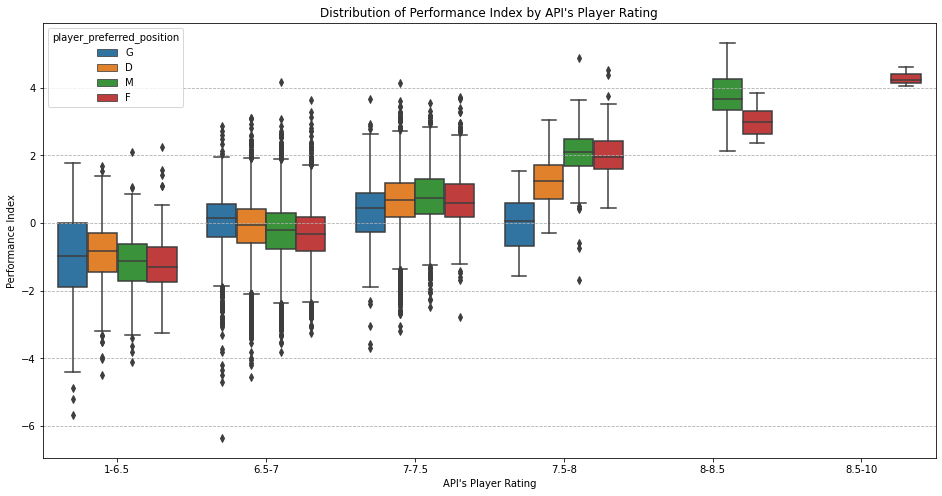

In [115]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="cat_player_rating", y="Perf_Index_norm", data=df_idx_all_players,
            order=['1-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-10'], hue='player_preferred_position', ax=ax)
ax.set_title("Distribution of Performance Index by API's Player Rating")
ax.set_ylabel("Performance Index")
ax.set_xlabel("API's Player Rating")
ax.yaxis.grid(linestyle='--')

In [108]:
df_idx_all_players

Unnamed: 0  league_season  team_id        team_name  player_id  \
0               0           2019     2540    Universitario      39868   
1               1           2017      209        Feyenoord      37137   
2               2           2018     2328       Huachipato      11657   
3               3           2017       42          Arsenal        313   
4               4           2016     1146         Cortulua      81642   
...           ...            ...      ...              ...        ...   
28961       28961           2021     2315        Colo Colo      11431   
28962       28962           2020     1063    Saint Etienne      24811   
28963       28963           2020      762      GIL Vicente     112386   
28964       28964           2016      461  San Martin S.J.       5592   
28965       28965           2021     2316     Curico Unido     337948   

             player_name player_preferred_position  wavg_player_rating  \
0        Patrick Zubczuk                         G                7.10   
1          Justin Bijlow                         G                7.00   
2             Yerko Urra                         G                6.60   
3           David Ospina                         G                7.06   
4         Jaiber Cardona                         G                7.37   
...                  ...                       ...                 ...   
28961  Carlos Villanueva                         F                6.54   
28962    Anthony Modeste                         F                6.53   
28963              Renan                         F                6.58   
28964       Diego Chaves                         F                6.50   
28965         Ian Aliaga                         F                6.48   

       Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Perf_Index  \
0          0.32      2.46     -0.19      0.11      1.68        0.88   
1          0.34      1.61     -0.57      0.10      2.18        0.69   
2          1.40      1.52      0.45      0.07     -0.67        0.67   
3          0.17      2.52      0.14      0.15     -0.04        0.67   
4         -0.27      2.37     -0.13      0.13      1.08        0.65   
...         ...       ...       ...       ...       ...         ...   
28961     -1.33     -0.39     -0.95     -2.07     -0.05       -0.92   
28962     -1.11     -0.55     -0.49     -2.36     -0.55       -0.93   
28963     -0.69     -0.99     -0.79     -2.37     -0.40       -0.93   
28964     -1.15     -0.86     -0.38     -2.38     -0.59       -0.99   
28965     -1.36     -0.46     -1.03     -2.33     -0.03       -0.99   

       Factor_1_scaled  Factor_2_scaled  Factor_3_scaled  Factor_4_scaled  \
0                 0.54             0.98             0.66             0.99   
1                 0.54             0.78             0.60             0.99   
2                 0.92             0.75             0.78             0.99   
3                 0.48             0.99             0.72             1.00   
4                 0.33             0.96             0.68             1.00   
...                ...              ...              ...              ...   
28961             0.01             0.11             0.14             0.07   
28962             0.05             0.08             0.29             0.01   
28963             0.14             0.00             0.19             0.00   
28964             0.04             0.02             0.32             0.00   
28965             0.00             0.09             0.12             0.01   

       Factor_5_scaled  Perf_Index_scaled cat_player_rating  Perf_Index_norm  
0                 0.65               1.00             7-7.5             3.67  
1                 0.73               0.93             7-7.5             2.94  
2                 0.27               0.92             6.5-7             2.88  
3                 0.37               0.92             7-7.5             2.87  
4                 0.55               0.91             7-7.5         